In [12]:
import sys
sys.path.append('/cellar/users/zkoch/methylation_and_mutation/source_files')
%load_ext autoreload
%aimport mutation_features, methylation_pred, somatic_mut_clock
%autoreload 1
import get_data, analysis, utils, plotting, compute_comethylation, methyl_mut_burden, mutation_features, methylation_pred

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
import pickle
import dask.dataframe as dd
from scipy.stats import spearmanr
from rich.progress import track
import statsmodels.formula.api as smf
import matplotlib.ticker as ticker
import colorcet as cc
from scipy.stats import spearmanr
from scipy import stats
import dask
import sklearn
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV

%config InlineBackend.figure_format = 'retina'
plt.style.use("seaborn-deep")

In [3]:
out_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/022023_output"
dependency_f_dir = "./dependency_files"
data_dir = "./data"
corr_dir = '/cellar/users/zkoch/methylation_and_mutation/dependency_files/chr_dset_corrs'
#methylation_dir = '/cellar/users/zkoch/methylation_and_mutation/data/dropped3SD_qnormed_methylation'
methylation_dir = '/cellar/users/zkoch/methylation_and_mutation/data/processed_methylation'
icgc_dir = "/cellar/users/zkoch/methylation_and_mutation/data/icgc"

# TCGA

### Get data

In [4]:
illumina_cpg_locs_df, all_mut_df, all_methyl_df, all_methyl_df_t, all_meta_df, dataset_names_list = get_data.main(
    illum_cpg_locs_fn = os.path.join(dependency_f_dir, "illumina_cpg_450k_locations.csv"),
    out_dir = out_dir,
    methyl_dir = methylation_dir,
    mut_fn = os.path.join(data_dir, "PANCAN_mut.tsv.gz"),
    meta_fn = os.path.join(data_dir, "PANCAN_meta.tsv"))

Got mutations and metadata, reading methylation
Converting Dask df to pandas df, takes ~10min
Got methylation, transposing
Done


In [5]:
# read in other already computed files
mut_in_measured_cpg_w_methyl_age_df = pd.read_parquet(os.path.join(dependency_f_dir, "mut_in_measured_cpg_w_methyl_age_df_5year.parquet"))
all_mut_w_age_df, all_methyl_age_df_t = utils.add_ages_to_mut_and_methyl(all_mut_df, all_meta_df, all_methyl_df_t)

# ICGC

### Get data

In [80]:
icgc_mut_df = pd.read_parquet("/cellar/users/zkoch/methylation_and_mutation/data/icgc/for_matrixQTL/icgc_mut_df.parquet")
icgc_meta_df = pd.read_parquet("/cellar/users/zkoch/methylation_and_mutation/data/icgc/for_matrixQTL/icgc_meta_df.parquet")
illumina_cpg_locs_df = get_data.get_illum_locs(os.path.join(dependency_f_dir, "illumina_cpg_450k_locations.csv"))
icgc_methyl_dd = dd.read_parquet('/cellar/users/zkoch/methylation_and_mutation/data/icgc/methyl_dir')
icgc_methyl_df = icgc_methyl_dd.compute()
icgc_methyl_df_t = icgc_methyl_df.T
shared_samples = set(icgc_methyl_df_t.index) & set(icgc_mut_df['sample'].unique()) & set(icgc_meta_df['sample'].unique())
icgc_methyl_df_t = icgc_methyl_df_t.loc[shared_samples]
icgc_methyl_df_t.dropna(how = 'any', axis=1, inplace=True)
icgc_mi_df = pd.read_parquet('/cellar/users/zkoch/methylation_and_mutation/output_dirs/011723_output/icgc_mi.parquet')
icgc_mi_df.sort_values(by='mutual_info', ascending=False, inplace=True)

In [30]:
icgc_meta_df['dataset'].value_counts()

PRAD-CA    241
PACA-AU    167
OV-AU       93
PBCA-DE     74
CLLE-ES     55
PAEN-AU     22
UTCA-FR     17
PRAD-UK      3
Name: dataset, dtype: int64

In [81]:
# rename columns 
icgc_mut_df.rename(columns={'chromosome':'chr', 'sample': 'case_submitter_id', 'chromosome_start':'start', 'MAF': 'DNA_VAF'}, inplace=True)
icgc_meta_df.rename(columns={'sample': 'case_submitter_id'}, inplace=True)
# merge with mut
icgc_mut_w_age_df = icgc_mut_df.merge(icgc_meta_df, on='case_submitter_id', how='left')
# and methyl dfs
icgc_meta_df_to_merge = icgc_meta_df[['case_submitter_id', 'age_at_index', 'dataset', 'gender']]
icgc_meta_df_to_merge.set_index('case_submitter_id', inplace=True)
# make gender column uppercase
icgc_meta_df_to_merge['gender'] = icgc_meta_df_to_merge['gender'].str.upper()
icgc_methyl_age_df_t = icgc_methyl_df_t.merge(icgc_meta_df_to_merge, left_index=True, right_index=True, how='left')

/tmp/ipykernel_1597874/2635062645.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  icgc_meta_df_to_merge['gender'] = icgc_meta_df_to_merge['gender'].str.upper()


# TODO

In [ ]:
"""
1) Profile what the slowest part of creating feature matrices is and/or parallelize (either through bash jobs or python)
2) Wrap the whole thing in a 5 fold cross validation, so changing the training and testing samples each time
2) for some reason the training samples are not getting subset correctly
3) Get the ICGC data to work
"""

# Epi-clock modelling

### How many CpGs are necessary?

In [304]:
# choose which CpGs to generate features for
corrs = mut_feat.all_methyl_age_df_t.loc[mut_feat.train_samples].corrwith(mut_feat.all_methyl_age_df_t.loc[mut_feat.train_samples, 'age_at_index'])
corrs.drop(['age_at_index', 'gender_MALE', 'gender_FEMALE'], inplace=True)
corrs = corrs.to_frame()
corrs.columns = ['corr']

In [303]:
corrs.to_parquet('/cellar/users/zkoch/methylation_and_mutation/dependency_files/cpg_age_corrs/SKCM_cpg_age_corrs.parquet')

,corr
cg13212963,-0.086806
cg26582803,0.050500
cg14150907,0.097212
cg08424876,-0.041250
cg09636313,-0.044279
...,...
cg11697588,0.065073
cg05375744,0.008874
cg05502283,0.063071
cg12404990,-0.087943


In [213]:
mi_combined = pd.read_parquet("/cellar/users/zkoch/methylation_and_mutation/dependency_files/mutual_informations/tcga_combinedMI_top10MI.parquet")
mi_df = mi_combined['SKCM']
mi_df = mi_df.to_frame()
mi_df.columns = ['mutual_info']

In [299]:
corrs.drop('cg17341477', inplace=True)

In [298]:
set(corrs.index) - set(mi_df.index)

{'cg17341477'}

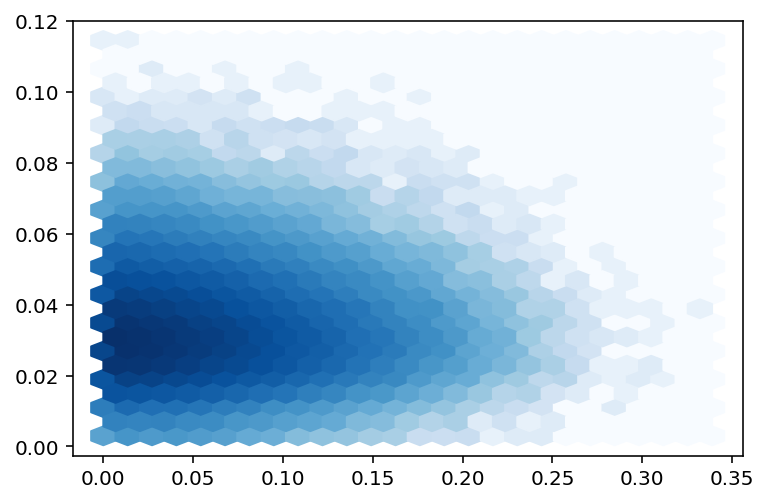

In [302]:
plt.hexbin(np.abs(corrs['corr']), mi_df['mutual_info'], gridsize=25, cmap='Blues', bins='log')

In [224]:
mut_feat = mutation_features.mutationFeatures(
    all_mut_w_age_df = all_mut_w_age_df, illumina_cpg_locs_df = illumina_cpg_locs_df, 
    all_methyl_age_df_t = all_methyl_age_df_t, out_dir = out_dir, consortium = 'TCGA', dataset = 'SKCM',
    cross_val_num = 0,
    matrix_qtl_dir = "/cellar/users/zkoch/methylation_and_mutation/data/matrixQtl_data/muts"
    )
cpg_pred_priority_corr = mut_feat.choose_cpgs_to_train(metric_df = corrs, bin_size = 20000, sort_by=['corr', 'mean_count'], mean = True)
cpg_pred_priority_mi = mut_feat.choose_cpgs_to_train(metric_df = mi_df, bin_size = 20000, sort_by=['mutual_info', 'mean_count'], mean = True)

In [229]:
cpg_pred_priority_corr['abs_corr'] = cpg_pred_priority_corr['corr'].abs()
cpg_pred_priority_corr.sort_values(by='abs_corr', ascending=False, inplace=True)
corr_chosen_cpgs_lists = []
for i in [1, 10, 100, 1000, 10000]:
    corr_chosen_cpgs_lists.append(cpg_pred_priority_corr.iloc[:i]['#id'].tolist())

In [ ]:
r2s, maes = [], []
for chosen_cpgs in corr_chosen_cpgs_lists:
    model = sklearn.linear_model.ElasticNetCV(max_iter=10000, cv=3, n_jobs=-1)

    X = all_methyl_age_df_t.loc[mut_feat.train_samples, chosen_cpgs]
    y = all_methyl_age_df_t.loc[mut_feat.train_samples, 'age_at_index']
    # fit actual methylation values of training samples
    model.fit(X, y)

    preds_age = model.predict(mut_feat.all_methyl_age_df_t.loc[mut_feat.test_samples, chosen_cpgs])
    actual_age = mut_feat.all_methyl_age_df_t.loc[mut_feat.test_samples, 'age_at_index']
    r2s.append(np.corrcoef(preds_age, actual_age)[0,1]**2)
    maes.append(sklearn.metrics.mean_absolute_error(preds_age, actual_age))
    print("done", flush=True)
print(r2s)

In [231]:
# same for mutual information
cpg_pred_priority_mi.sort_values(by='mutual_info', ascending=False, inplace=True)
mi_chosen_cpgs_lists = []
for i in [1, 10, 100, 1000, 10000]:
    mi_chosen_cpgs_lists.append(cpg_pred_priority_mi.iloc[:i]['#id'].tolist())

In [232]:
r2s, maes = [], []
for chosen_cpgs in mi_chosen_cpgs_lists:
    model = sklearn.linear_model.ElasticNetCV(max_iter=10000, cv=3, n_jobs=-1)

    X = all_methyl_age_df_t.loc[mut_feat.train_samples, chosen_cpgs]
    y = all_methyl_age_df_t.loc[mut_feat.train_samples, 'age_at_index']
    # fit actual methylation values of training samples
    model.fit(X, y)

    preds_age = model.predict(mut_feat.all_methyl_age_df_t.loc[mut_feat.test_samples, chosen_cpgs])
    actual_age = mut_feat.all_methyl_age_df_t.loc[mut_feat.test_samples, 'age_at_index']
    r2s.append(np.corrcoef(preds_age, actual_age)[0,1]**2)
    maes.append(sklearn.metrics.mean_absolute_error(preds_age, actual_age))
    print("done", flush=True)
print(r2s)

done
done
done
done
done
[0.022203061831685408, 0.09932204938003975, 0.0857762818505133, 0.1551099480720156, 0.23800466146008298]


In [247]:
r2s

[0.022203061831685408,
 0.09932204938003975,
 0.0857762818505133,
 0.1551099480720156,
 0.23800466146008298]

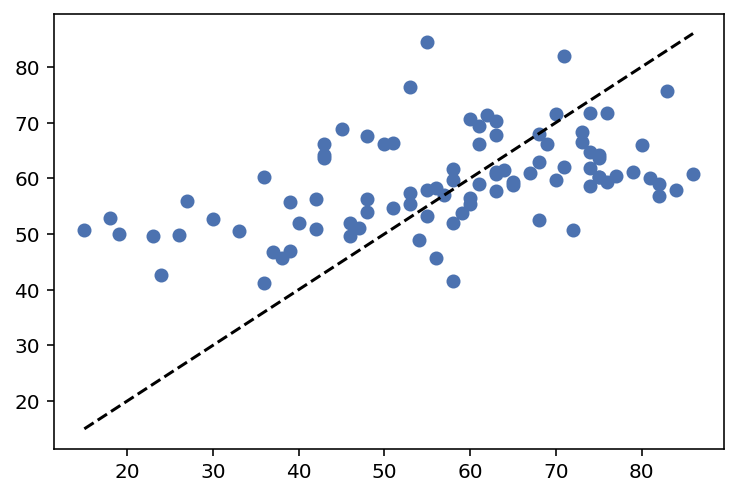

In [235]:
plt.scatter(actual_age, preds_age)
plt.plot([min(actual_age),max(actual_age)], [min(actual_age),max(actual_age)], c='black', linestyle='--')


# Mutation features

In [ ]:
godmc_meqtls = pd.read_parquet('/cellar/users/zkoch/methylation_and_mutation/data/meQTL/goDMC_meQTL/goDMC_meQTLs.parquet')

In [438]:
mut_feat = mutation_features.mutationFeatures(
    all_mut_w_age_df = all_mut_w_age_df, illumina_cpg_locs_df = illumina_cpg_locs_df, 
    all_methyl_age_df_t = all_methyl_age_df_t, meqtl_db = godmc_meqtls, out_dir = out_dir, consortium = 'TCGA', dataset = 'SKCM',
    cross_val_num = 0,
    matrix_qtl_dir = "/cellar/users/zkoch/methylation_and_mutation/data/matrixQtl_data/muts"
    )

In [54]:
corrs = mut_feat.all_methyl_age_df_t.loc[mut_feat.train_samples].corrwith(mut_feat.all_methyl_age_df_t.loc[mut_feat.train_samples, 'age_at_index'])
corrs.drop(['age_at_index', 'gender_MALE', 'gender_FEMALE'], inplace=True)
corrs = corrs.to_frame()
corrs.columns = ['corr']

In [305]:
cpg_pred_priority = mut_feat.choose_cpgs_to_train(metric_df = corrs, bin_size = 20000, sort_by=['corr', 'count'], mean = True)

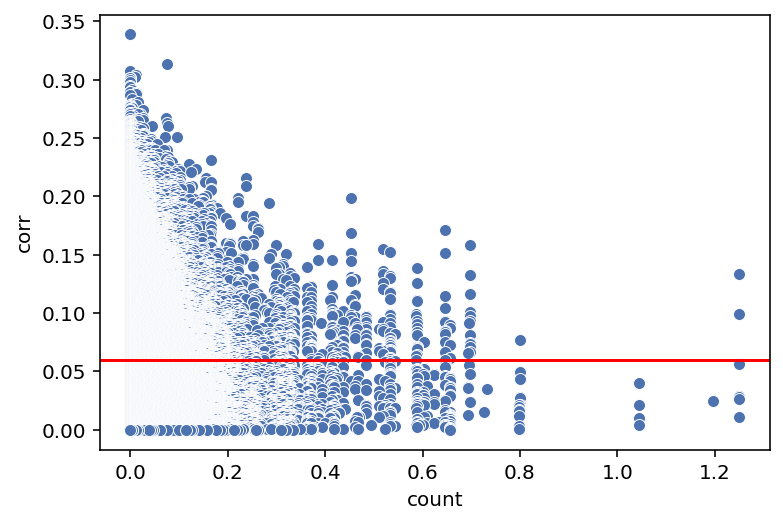

In [433]:
cpg_pred_priority['corr'] = cpg_pred_priority['corr'].abs()
sns.scatterplot(y='corr', x='count', data=cpg_pred_priority)
# draw lines y = .1 and y = -.1
plt.axhline(y=.06, color='r', linestyle='-')
# draw line x = .2

In [450]:
chosen_cpgs = cpg_pred_priority.loc[(np.abs(cpg_pred_priority['corr']) > .14) & (cpg_pred_priority['count'] > 0.08), '#id']
mut_feat.create_all_feat_mats(
    cpg_ids = ['cg20154947', 'cg05320382', 'cg26763284', 'cg08718031', 'cg23186643'], aggregate='Both',
    num_correl_sites=5000, num_correl_ext_sites=100, max_meqtl_sites=1000,
    nearby_window_size=25000, num_db_sites = 5000
    )
mut_feat_store_fn = mut_feat.save_mutation_features()

cg20154947
Finished 0 of 5
cg05320382
cg26763284
cg08718031
cg23186643
Saved mutation features to
/cellar/users/zkoch/methylation_and_mutation/output_dirs/022023_output/TCGA_SKCM_5000correl_100correlExt_1000meqtl_25000nearby_Bothagg_5numCpGs_startTopCpGs_crossValNum/TCGA_SKCM_5000correl_100correlExt_1000meqtl_25000nearby_Bothagg_5numCpGs_startTopCpGs_crossValNum.features.pkl


In [105]:
mut_feat_store_fns = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/022323_output/TCGA_SKCM_5000correl_100correlExt_1000meqtl_50000nearby_Bothagg_3333*/*features.pkl")
trained_models_fn = os.path.join(mut_feat_store_fns[0][:mut_feat_store_fns[0].rfind('/')], "trained_models_elasticNet.pkl")

# train predictors for these cpgs
methyl_pred = methylation_pred.methylationPrediction(
    mut_feat_store_fns = [mut_feat_store_fns[0]],
    model_type = 'elasticNet',
    scramble = False,
    trained_models_fns = [trained_models_fn]
    )
#methyl_pred.train_all_models()
methyl_pred.apply_all_models()
methyl_pred.save_models_and_preds()

Done reading /cellar/users/zkoch/methylation_and_mutation/output_dirs/022323_output/TCGA_SKCM_5000correl_100correlExt_1000meqtl_50000nearby_Bothagg_3333numCpGs_93324startTopCpGs_0crossValNum/TCGA_SKCM_5000correl_100correlExt_1000meqtl_50000nearby_Bothagg_3333numCpGs_93324startTopCpGs_0crossValNum.features.pkl
Predicted methylation for 0 CpGs of 3333


/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packag

Predicted methylation for 100 CpGs of 3333


/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packag

Predicted methylation for 200 CpGs of 3333


/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packag

Predicted methylation for 300 CpGs of 3333


/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packag

Predicted methylation for 400 CpGs of 3333


/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packag

Predicted methylation for 500 CpGs of 3333


/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packag

Predicted methylation for 600 CpGs of 3333


/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packag

Predicted methylation for 700 CpGs of 3333


/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packag

Predicted methylation for 800 CpGs of 3333


/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packag

Predicted methylation for 900 CpGs of 3333


/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packag

Predicted methylation for 1000 CpGs of 3333


/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packag

Predicted methylation for 1100 CpGs of 3333


/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packag

Predicted methylation for 1200 CpGs of 3333


/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packag

Predicted methylation for 1300 CpGs of 3333


/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packag

Predicted methylation for 1400 CpGs of 3333


/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packag

Predicted methylation for 1500 CpGs of 3333


/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packag

Predicted methylation for 1600 CpGs of 3333


/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packag

Predicted methylation for 1700 CpGs of 3333


/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packag

Predicted methylation for 1800 CpGs of 3333


/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packag

Predicted methylation for 1900 CpGs of 3333


/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packag

Predicted methylation for 2000 CpGs of 3333


/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packag

Predicted methylation for 2100 CpGs of 3333


/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packag

Predicted methylation for 2200 CpGs of 3333


/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packag

Predicted methylation for 2300 CpGs of 3333


/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packag

Predicted methylation for 2400 CpGs of 3333


/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packag

Predicted methylation for 2500 CpGs of 3333


/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packag

Predicted methylation for 2600 CpGs of 3333


/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packag

Predicted methylation for 2700 CpGs of 3333


/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packag

Predicted methylation for 2800 CpGs of 3333


/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packag

Predicted methylation for 2900 CpGs of 3333


/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packag

Predicted methylation for 3000 CpGs of 3333


/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packag

Predicted methylation for 3100 CpGs of 3333


/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packag

Predicted methylation for 3200 CpGs of 3333


/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packag

Predicted methylation for 3300 CpGs of 3333


/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/cellar/users/zkoch/miniconda3/envs/big_data/lib/python3.9/site-packag

wrote out trained models, predictions, and performances to /cellar/users/zkoch/methylation_and_mutation/output_dirs/022323_output/TCGA_SKCM_5000correl_100correlExt_1000meqtl_50000nearby_Bothagg_3333numCpGs_93324startTopCpGs_0crossValNum


In [351]:
methyl_pred.perf_df['age_corr'] = methyl_pred.pred_df.corrwith(mut_feat.all_methyl_age_df_t.loc[methyl_pred.test_samples, 'age_at_index'])
methyl_pred.perf_df['count'] = cpg_pred_priority.loc[(np.abs(cpg_pred_priority['corr']) > .14) & (cpg_pred_priority['count'] > 0.08), 'count'].to_list()
methyl_pred.perf_df['real_age_corr'] = cpg_pred_priority.loc[(np.abs(cpg_pred_priority['corr']) > .14) & (cpg_pred_priority['count'] > 0.08), 'corr'].to_list()

0.0128930910165799
0.010259910775147187
0.000506552060642544
0.031676478429084776


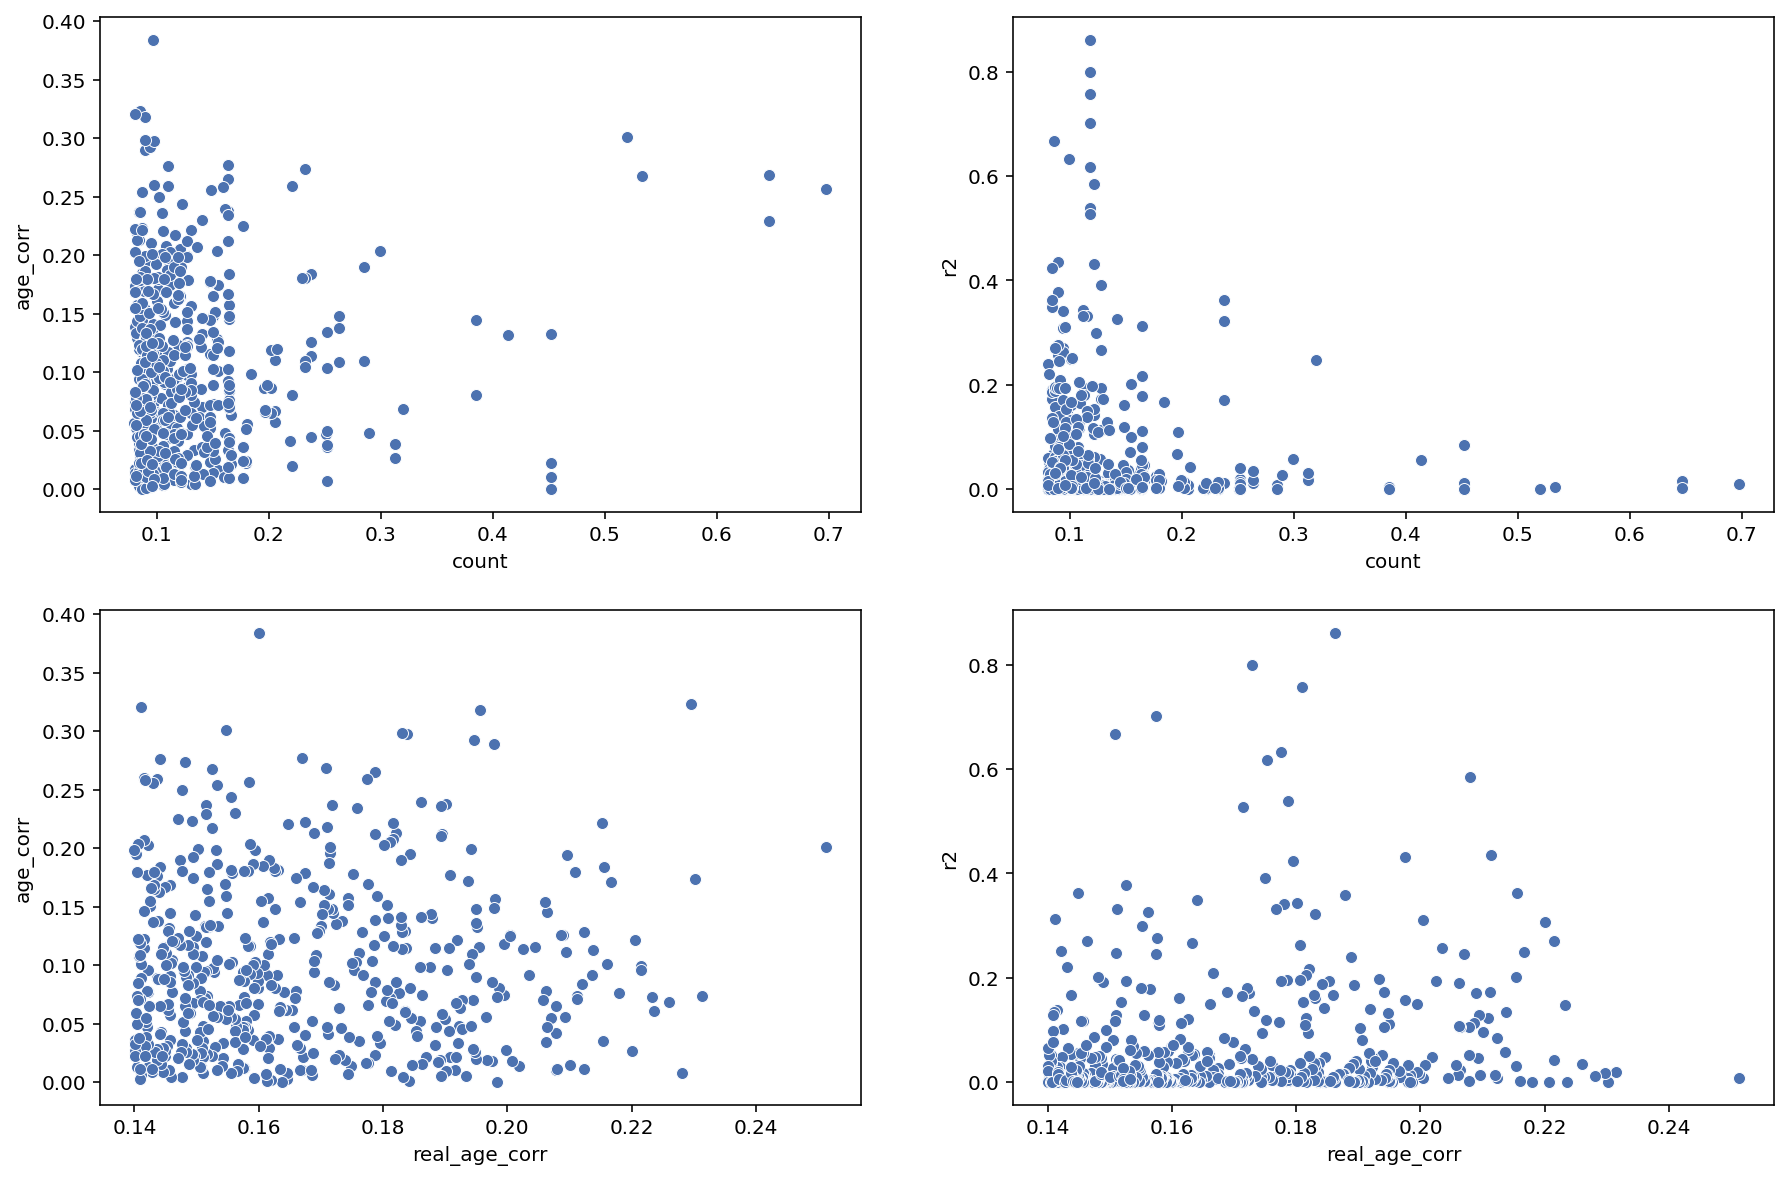

In [358]:
fig, axes = plt.subplots(2,2, figsize=(15,10))
axes = axes.flatten()
sns.scatterplot(data = np.abs(methyl_pred.perf_df), x='count', y='age_corr', ax = axes[0])
sns.scatterplot(data = np.abs(methyl_pred.perf_df), x='count', y='r2', ax = axes[1])
sns.scatterplot(data = np.abs(methyl_pred.perf_df), x='real_age_corr', y='age_corr', ax = axes[2])
sns.scatterplot(data = np.abs(methyl_pred.perf_df), x='real_age_corr', y='r2', ax = axes[3])
# print r2 beteween each of these vlaues
print(np.corrcoef(np.abs(methyl_pred.perf_df)['count'], np.abs(methyl_pred.perf_df)['age_corr'])[0,1]**2)
print(np.corrcoef(np.abs(methyl_pred.perf_df)['count'], np.abs(methyl_pred.perf_df)['r2'])[0,1]**2)
print(np.corrcoef(np.abs(methyl_pred.perf_df)['real_age_corr'],np.abs(methyl_pred.perf_df)['age_corr'])[0,1]**2)
print(np.corrcoef(np.abs(methyl_pred.perf_df)['real_age_corr'], np.abs(methyl_pred.perf_df)['r2'])[0,1]**2)


In [361]:
model = sklearn.linear_model.ElasticNetCV(max_iter=100000)
import xgboost as xgb
#model = xgb.XGBRegressor()
#model = sklearn.linear_model.LinearRegression()

X = all_methyl_age_df_t.loc[mut_feat.train_samples, methyl_pred.pred_df.columns]
y = all_methyl_age_df_t.loc[mut_feat.train_samples, 'age_at_index']
# fit actual methylation values of training samples
model.fit(X, y)

preds = model.predict(methyl_pred.pred_df[methyl_pred.pred_df.columns])
preds_real_methyl = model.predict(mut_feat.all_methyl_age_df_t.loc[mut_feat.test_samples, methyl_pred.pred_df.columns])
actual = mut_feat.all_methyl_age_df_t.loc[mut_feat.test_samples, 'age_at_index']

R2 for predicted methylation epi clock 0.08630977462063329
R2 for real methylation epi clock 0.10352442461434146


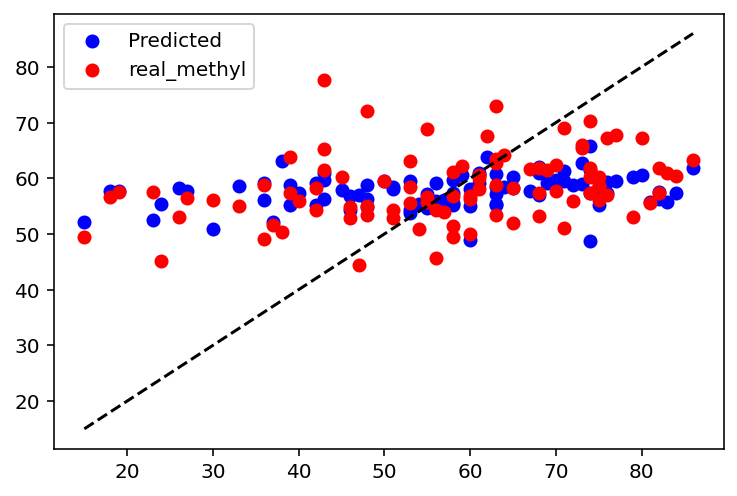

In [362]:
plt.scatter(actual, preds, c = 'blue', label = 'Predicted')
plt.scatter(actual, preds_real_methyl, c = 'red', label = 'real_methyl')
plt.legend()
# plot y = x line
plt.plot([min(actual),max(actual)], [min(actual),max(actual)], c='black', linestyle='--')
print(f"R2 for predicted methylation epi clock {np.corrcoef(actual, preds)[0,1]**2}")
print(f"R2 for real methylation epi clock {np.corrcoef(actual, preds_real_methyl)[0,1]**2}")

In [369]:
methyl_pred.perf_df.sort_values('age_corr', ascending=False)

,r2,mae,age_corr,count,real_age_corr
cg00765922,0.000088,0.248632,0.384025,0.096591,0.160095
cg24361162,0.018045,0.159382,0.323402,0.085227,0.229638
cg14826711,0.003470,0.177171,0.320968,0.080229,0.141105
cg07845648,0.036296,0.119203,0.317775,0.089552,0.195576
cg17047981,0.000079,0.052652,0.301167,0.519520,0.154751
...,...,...,...,...,...
cg11717557,0.007425,0.009512,-0.222169,0.080556,0.167449
cg26063106,0.000777,0.105201,-0.230155,0.140127,0.156248
cg06033773,0.002227,0.014244,-0.249694,0.101983,0.147603
cg24144047,0.024085,0.132164,-0.259165,0.110236,0.177442


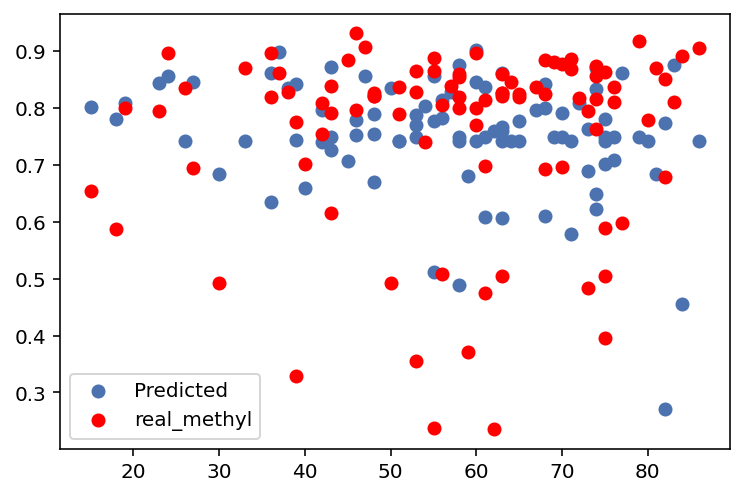

In [374]:
plt.scatter(all_methyl_age_df_t.loc[methyl_pred.pred_df.index, 'age_at_index'], methyl_pred.pred_df['cg24144047'], label = 'Predicted')
plt.scatter(all_methyl_age_df_t.loc[methyl_pred.pred_df.index, 'age_at_index'], all_methyl_age_df_t.loc[methyl_pred.pred_df.index, 'cg24144047'], c='red', label = 'real_methyl')
plt.legend()

#### Read in predicted methylation

In [17]:
pred_methyl_fns = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/022323_output/TCGA_SKCM_5000correl_100correlExt_1000meqtl_50000nearby_Bothagg_3333*/methyl_predictions*parquet")
pred_perf_fns = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/022323_output/TCGA_SKCM_5000correl_100correlExt_1000meqtl_50000nearby_Bothagg_3333*/prediction_performance_xgboost*parquet")

In [54]:
mut_clock = somatic_mut_clock.mutationClock(
            predicted_methyl_fns = pred_methyl_fns,
            predicted_perf_fns = pred_perf_fns,
            all_methyl_age_df_t = all_methyl_age_df_t,
            illumina_cpg_locs_df = illumina_cpg_locs_df,
            output_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/022323_output",
            tissue_type = ''
            )

In [72]:
mut_clock.performance_df['age_r2'] =  mut_clock.predicted_methyl_df.corrwith(mut_clock.all_methyl_age_df_t.loc[mut_clock.predicted_methyl_df.index, 'age_at_index'])

In [75]:
mut_clock.performance_df['age_r2'].min()

-0.3571063490099553

In [61]:
# want to train a clock on the same CpGs that we predicted on in training samples real data
mut_clock.train_epi_clock(
        samples = mut_clock.train_samples,
        cpgs = mut_clock.predicted_methyl_df.columns
        )
# then apply this clock to test samples real and predicted data

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 35.1min finished


In [62]:
predicted_ages = mut_clock.apply_epi_clock(
    X = mut_clock.predicted_methyl_df
    )

In [78]:
all_methyl_age_df_t.index.get_indexer(mut_clock.test_samples)

array([6619, 6620, 6621, 6622, 6623, 6624, 6625, 6626, 6627, 6628, 6629,
       6630, 6631, 6632, 6633, 6634, 6635, 6636, 6637, 6638, 6639, 6640,
       6641, 6642, 6643, 6644, 6645, 6646, 6647, 6648, 6649, 6650, 6651,
       6652, 6653, 6654, 6655, 6656, 6657, 6658, 6659, 6660, 6661, 6662,
       6663, 6664, 6665, 6666, 6667, 6668, 6669, 6670, 6671, 6672, 6673,
       6674, 6675, 6676, 6677, 6678, 6679, 6680, 6681, 6682, 6683, 6684,
       6685, 6686, 6687, 6688, 6689, 6690, 6691, 6692, 6693, 6694, 6695,
       6696, 6697, 6698, 6699, 6700, 6701, 6702, 6703, 6704, 6705, 6706,
       6707, 6708, 6709, 6710])

# ICGC testing

In [230]:
icgc_mut_feat = mutation_features.mutationFeatures(
    all_mut_w_age_df = icgc_mut_w_age_df, illumina_cpg_locs_df = illumina_cpg_locs_df, 
    all_methyl_age_df_t = icgc_methyl_age_df_t, out_dir = out_dir, dataset = 'PRAD-CA',
    consortium = 'ICGC', train_samples = train, test_samples = test,
    matrix_qtl_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/icgc_muts_011423"
    )

In [289]:
icgc_cpg_pred_priority = icgc_mut_feat.choose_cpgs_to_train(mi_df = icgc_mi_df, bin_size=20000, sort_by=['mutual_info', 'count'])
icgc_mut_feat.create_all_feat_mats(
    cpg_ids = icgc_cpg_pred_priority.head(10)['#id'].to_list(), aggregate='Both',
    num_correl_sites=5000, num_correl_ext_sites=100, max_meqtl_sites=100,
    nearby_window_size=25000
    )

Finished 0 of 10


In [ ]:
mut_feat_store_fns = glob.glob('/cellar/users/zkoch/methylation_and_mutation/output_dirs/020723_output/ICGC__5000correl_100correlExt_100meqtl_25000nearby_Bothagg_2500numCpGs_*/*features.pkl')
# train predictors for these cpgs
icgc_methyl_pred = methylation_pred.methylationPrediction(
    mut_feat_store_fns = mut_feat_store_fns,
    model_type = 'xgboost'
    )
icgc_methyl_pred.train_all_models()
icgc_methyl_pred.apply_all_models()
icgc_methyl_pred.save_models_and_preds()

In [102]:
train_df = icgc_methyl_age_df_t.loc[icgc_methyl_pred.train_samples, icgc_methyl_pred.mut_feat_store['cpg_ids']]
train_ages = icgc_methyl_age_df_t.loc[icgc_methyl_pred.train_samples, 'age_at_index'].dropna()
train_df = train_df.loc[train_ages.index, :]

test_df = icgc_methyl_pred.pred_df
test_ages = icgc_methyl_age_df_t.loc[icgc_methyl_pred.test_samples, 'age_at_index']
model = ElasticNetCV(cv=5, random_state=0, max_iter=10000, n_jobs=-1, verbose=1)
# train the model on the training set
model.fit(train_df, train_ages)
# predict the ages on the test set
pred_ages = model.predict(test_df)

0.8288474017235258

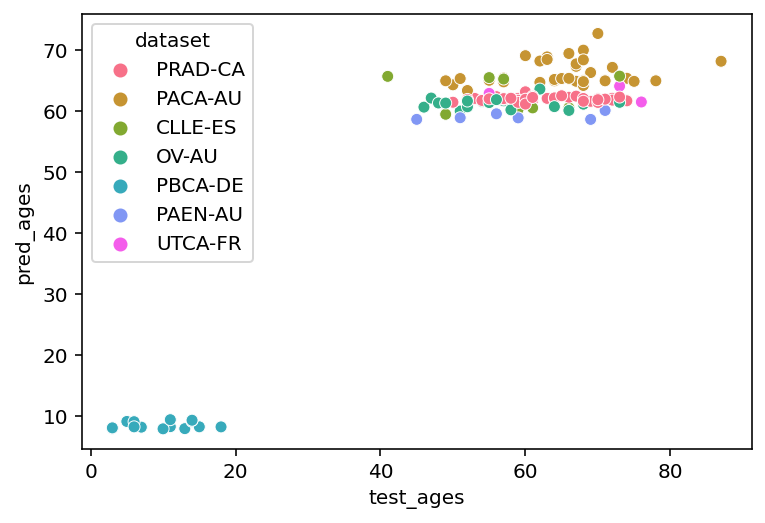

In [113]:
to_plot = pd.DataFrame({'pred_ages':pred_ages, 'test_ages':test_ages, 'dataset': icgc_methyl_age_df_t.loc[icgc_methyl_pred.test_samples, 'dataset'].to_list()})
sns.scatterplot(data=to_plot, x='test_ages', y='pred_ages', hue='dataset')
print(np.corrcoef(test_ages, pred_ages)[0][1]**2